In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR

from libs.datasets import CDSDataset, JHUDataset
from libs.datasets import DHBeds, FIPSPopulation
from libs.datasets.dataset_utils import AggregationLevel
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import matplotlib and related libraries
%matplotlib inline
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
timeseries_data = JHUDataset.local().timeseries()
beds_data = DHBeds.local().beds()
population_data = FIPSPopulation.local().population()

Did not match 5 codes to county data.
['60000', '66000', '69000', '78000', '88888']
Could not match ('AS', 'American Samoa')
Could not match ('GU', 'Guam')
Could not match ('VI', 'Saint Croix')
Could not match ('MP', 'Saipan')
Could not match ('VI', 'Saint Thomas')


In [5]:
def model_state(country, state, interventions=None):
   
    # we should cut this, only used by the get_timeseries function, but probably not needed
    MODEL_INTERVAL = 4

    # Pack all of the assumptions and parameters into a dict that can be passed into the model    
    DATA_PARAMETERS = {
        'timeseries': timeseries_data.get_subset(AggregationLevel.STATE).get_data(country=country, state=state),
        'beds': beds_data.get_state_level(state),
        'population': population_data.get_state_level(country, state)
    }
    
    MODEL_PARAMETERS = {        
        #'model': 'seir',
        'model': 'asymp',
        'model_cols': ["total", "susceptible", "exposed", "infected", "asymp", "infected_a", "infected_b", "infected_c", "recovered", "dead",],
        
        'use_harvard_params': False, #If True use the harvard parameters directly, if not calculate off the above
        'fix_r0': False, #If True use the parameters that make R0 2.4, if not calculate off the above
        
        'days_to_model': 270,

        ## Variables for calculating model parameters Hill -> our names/calcs    
        # IncubPeriod: Average incubation period, days - presymptomatic_period
        # DurMildInf: Average duration of mild infections, days - duration_mild_infections
        # FracMild: Average fraction of (symptomatic) infections that are mild - (1 - hospitalization_rate)
        # FracSevere: Average fraction of (symptomatic) infections that are severe - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # FracCritical: Average fraction of (symptomatic) infections that are critical - hospitalization_rate * hospitalized_cases_requiring_icu_care
        # CFR: Case fatality rate (fraction of infections that eventually result in death) - case_fatality_rate
        # DurHosp: Average duration of hospitalization (time to recovery) for individuals with severe infection, days - hospital_time_recovery
        # TimeICUDeath: Average duration of ICU admission (until death or recovery), days - icu_time_death 
        
        # LOGIC ON INITIAL CONDITIONS:
        # hospitalized = case load from timeseries on last day of data / 4
        # mild = hospitalized / hospitalization_rate
        # icu = hospitalized * hospitalized_cases_requiring_icu_care
        # expoosed = exposed_infected_ratio * mild
        
        # Time before exposed are infectious (days)
        'presymptomatic_period': 3, 
        
        # Ratio of asymptomatic, infectious [A] people to
        # infected, mild symptoms [I_1] people (unitless)
        'asymp_to_mild_ratio': 1,

        # Time mildly infected people stay sick before
        # hospitalization or recovery (days)
        'duration_mild_infections': 6, 

        # Time asymptomatically infected people stay
        # infected before recovery (days)
        'duration_asymp_infections': 6, 
        
        # Duration of hospitalization before icu or
        # recovery (days)
        'hospital_time_recovery': 6, 

        # Time from ICU admission to death (days)
        'icu_time_death': 8, 

        ###################################################
        # BETA: transmission rate (new cases per day). 
        # The rate at which infectious cases of various
        # classes cause secondary or new cases.
        ###################################################
        
        # Transmission rate of infected people with no
        # symptoms [A] (new cases per day)
        'beta_asymp': 0.6,
        #
        # Transmission rate of infected people with mild
        # symptoms [I_1] (new cases per day)
        'beta': 0.6,
        #
        # Transmission rate of infected people with severe
        # symptoms [I_2] (new cases per day)
        'beta_hospitalized': 0.1,
        #
        # Transmission rate of infected people with severe
        # symptoms [I_3] (new cases per day)
        'beta_icu': 0.1,
        #
        ###################################################
        
        "hospitalization_rate": 0.0727,
        "hospitalized_cases_requiring_icu_care": 0.1397,
        "case_fatality_rate": 0.0109341104294479,
        
        'exposed_from_infected': True,
        
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,     

        'interventions': interventions,
        'observed_daily_growth_rate': 1.21,
    }
    
    MODEL_PARAMETERS['beta'] = (0.3 + ( (MODEL_PARAMETERS["observed_daily_growth_rate"] - 1.09) / 0.02) * 0.05)
    
    MODEL_PARAMETERS['case_fatality_rate_hospitals_overwhelmed'] = MODEL_PARAMETERS['hospitalization_rate'] * MODEL_PARAMETERS['hospitalized_cases_requiring_icu_care']
    
    MODEL_PARAMETERS['exposed_infected_ratio'] = 1
    
    MODEL_PARAMETERS.update(DATA_PARAMETERS)
    
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

INTERVENTIONS = [None, None, None, None]

In [6]:
#timeseries_data.get_subset(AggregationLevel.STATE).get_data('USA', 'TX', 1) #[['date','cases','deaths','recovered','active']]
#beds_data.get_state_level('NY')

In [7]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]

    x_dates = df['date'].dt.strftime('%Y-%m-%d').sort_values().unique()
        
    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))

    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    #df_plt.set_xticklabels(labels=x_dates, rotation=45, ha='right')

    return(df_plt)

In [8]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

         date  infected  recovered   dead       total  exposed  infected_a  \
51 2020-04-04       nan   10025.24 129.32 28995881.00 22821.14    13758.14   
52 2020-04-05       nan   13755.32 149.33 28995881.00 28363.68    15574.19   
53 2020-04-06       nan   18309.69 169.77 28995881.00 35047.42    18048.22   
54 2020-04-07       nan   23891.10 190.72 28995881.00 43205.20    21280.36   
55 2020-04-08       nan   30743.80 212.32 28995881.00 53208.09    25409.14   

    infected_b  infected_c    asymp  infected_tmp  
51      921.65      147.13  7249.21      22076.13  
52      943.55      150.23 10161.67      26829.64  
53      986.05      153.66 13599.20      32787.13  
54     1053.88      157.89 17688.91      40181.05  
55     1152.37      163.44 22593.75      49318.71  


In [9]:
df.iloc[25:].head(25)

,date,infected,recovered,dead,total,exposed,infected_a,infected_b,infected_c,asymp,susceptible,pct_change,doubling_time,beds
25,2020-03-09,14.00,0.00,0.00,28995881.00,0.00,14.00,0.00,0.00,0.00,28995853.00,nan,nan,73791
26,2020-03-10,13.00,0.00,0.00,28995881.00,0.00,13.00,0.00,0.00,0.00,28995855.00,nan,nan,73791
27,2020-03-11,21.00,0.00,0.00,28995881.00,0.00,21.00,0.00,0.00,0.00,28995839.00,nan,nan,73791
28,2020-03-12,27.00,0.00,0.00,28995881.00,0.00,27.00,0.00,0.00,0.00,28995827.00,nan,nan,73791
29,2020-03-13,43.00,0.00,0.00,28995881.00,0.00,43.00,0.00,0.00,0.00,28995795.00,nan,nan,73791
30,2020-03-14,57.00,0.00,0.00,28995881.00,0.00,57.00,0.00,0.00,0.00,28995767.00,nan,nan,73791
31,2020-03-15,72.00,0.00,0.00,28995881.00,0.00,72.00,0.00,0.00,0.00,28995737.00,nan,nan,73791
32,2020-03-16,85.00,0.00,0.00,28995881.00,0.00,85.00,0.00,0.00,0.00,28995711.00,nan,nan,73791
33,2020-03-17,109.00,0.00,1.00,28995881.00,0.00,109.00,0.00,0.00,0.00,28995662.00,nan,nan,73791
34,2020-03-18,170.00,0.00,3.00,28995881.00,0.00,170.00,0.00,0.00,0.00,28995538.00,nan,nan,73791


avg doubling time by week
      doubling_time
week               
7               nan
8               nan
9               nan
10              nan
11              nan
12              nan
13              nan
14           -24.08
15             7.43
16             3.33
17             3.21
18             3.84
19             7.11
20            -1.12
21           -18.67
22            -9.35
23            -7.43
24            -6.65
25            -6.24
26            -6.00
27            -5.86
28            -5.77
29            -5.70
30            -5.66
31            -5.63
32            -5.62
33            -5.61
34            -5.60
35            -5.60
36            -5.60
37            -5.60
38            -5.60
39            -5.61
40            -5.61
41            -5.62
42            -5.63
43            -5.64
44            -5.64
45            -5.65
46            -5.66
47            -5.67
48            -5.67
49            -5.68
50            -5.69
51            -5.70
52            -5.71


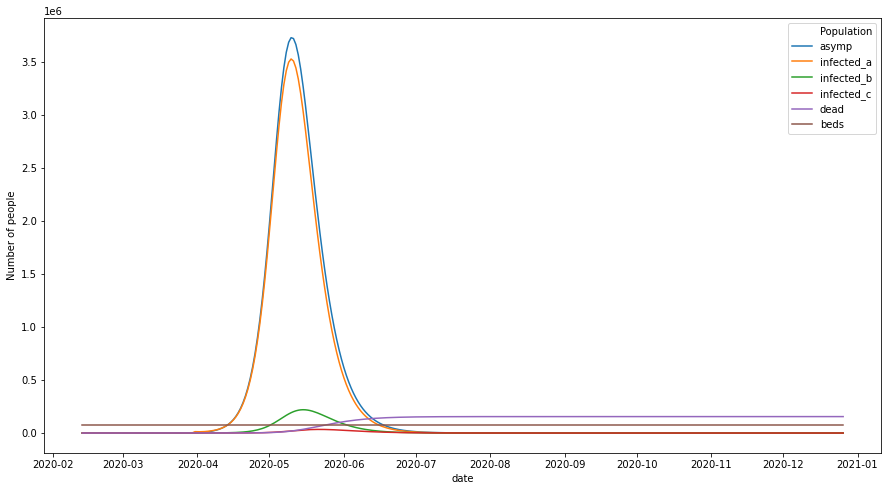

In [10]:
df['week'] = pd.DatetimeIndex(df['date']).week
avg_doubling_month = df.loc[:, ('week', 'doubling_time')].groupby('week').mean()

print('avg doubling time by week')
print(avg_doubling_month)

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["asymp", "infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(df, chart_cols)

In [11]:
use_harvard_init = False #If True use the harvard model inputs for inital conditions and N (recreate their graph)
#use_harvard_init = True #If True use the harvard model inputs for inital conditions and N (recreate their graph)

In [13]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

print(df.iloc[-1])
#print(initervention_df.iloc[-20])

df['month'] = pd.DatetimeIndex(df['date']).month
avg_doubling_month = df.loc[:, ('month', 'doubling_time')].groupby('month').mean()
print(chart_cols)
plot_df(df, chart_cols)

         date  infected  recovered   dead       total  exposed  infected_a  \
51 2020-04-04       nan   10025.24 129.32 28995881.00 22821.14    13758.14   
52 2020-04-05       nan   13755.32 149.33 28995881.00 28363.68    15574.19   
53 2020-04-06       nan   18309.69 169.77 28995881.00 35047.42    18048.22   
54 2020-04-07       nan   23891.10 190.72 28995881.00 43205.20    21280.36   
55 2020-04-08       nan   30743.80 212.32 28995881.00 53208.09    25409.14   

    infected_b  infected_c    asymp  infected_tmp  
51      921.65      147.13  7249.21      22076.13  
52      943.55      150.23 10161.67      26829.64  
53      986.05      153.66 13599.20      32787.13  
54     1053.88      157.89 17688.91      40181.05  
55     1152.37      163.44 22593.75      49318.71  
date             2020-12-26 00:00:00
infected                        0.00
recovered                28103474.02
dead                       154890.60
total                    28995881.00
exposed                         0.

AttributeError: 'DataFrame' object has no attribute 'dt'

In [ ]:
# df.head(25)

In [ ]:
[intervention_df, soln] = model_state('USA', 'TX', INTERVENTIONS[3])

In [ ]:
first_case_date = intervention_df.loc[(intervention_df.infected > 0), 'date'].min()
peak_date = intervention_df.loc[(intervention_df.infected_b == intervention_df.infected_b.max())]['date'].values[0]

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
#chart_cols = ["infected", "infected_b", "infected_c",  "dead"] #, "susceptible"]
plot_df(df, chart_cols)

In [ ]:
if use_harvard_init:
    tmax=365
    N = 1000
    tvec=np.arange(0,tmax,0.1)
else:
    # tmax = 80 * 4
    tmax = 365
    N =  28995881.00
    #N = 10000
    tvec=np.arange(0,tmax,1)
    
#print(np.array(N-np.sum(soln,axis=1,keepdims=True)))
#s = [N-np.sum(soln,axis=1,keepdims=True)]
#s = np.max(s,0)
soln_plt = np.hstack([soln])
#soln_plt = np.hstack(soln)

print('avg doubling time by month')
print(avg_doubling_month)

intervention_df['week'] = pd.DatetimeIndex(intervention_df['date']).week
avg_doubling_month = intervention_df.loc[:, ('week', 'doubling_time')].groupby('week').mean()

print('avg doubling time by week')
print(avg_doubling_month)

#chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead"] #, "susceptible"]
chart_cols = ["infected_a", "infected_b", "infected_c", "dead", "beds"] #, "susceptible"] "recovered",

plot_df(intervention_df, chart_cols)